https://pythonrepo.com/repo/jacobgil-pytorch-grad-cam

https://github.com/jacobgil/pytorch-grad-cam

|Method|What it does|
|:--:|:--|
|GradCAM|Weight the 2D activations by the average gradient|
|GradCAM++|Like GradCAM but uses second order gradients|
|XGradCAM|Like GradCAM but scale the gradients by the normalized activations|
|AblationCAM|Zero out activations and measure how the output drops (this repository includes a fast batched implementation)|
|ScoreCAM|Perbutate the image by the scaled activations and measure how the output drops|
|EigenCAM|Takes the first principle component of the 2D Activations (no class discrimination, but seems to give great results)|
|EigenGradCAM|Like EigenCAM but with class discrimination: First principle component of Activations*Grad. Looks like GradCAM, but cleaner|
|LayerCAM|Spatially weight the activations by positive gradients. Works better especially in lower layers|

# Import

In [1]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad, EigenGradCAM, LayerCAM
import torchvision
import torch
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from torchvision.models import resnet50

In [3]:
from fastai.vision.all import *
from torchvision import transforms

In [4]:
def label_func(f):
    if f[0].isupper():
        return 'cat' 
    else: 
        return 'dog' 

# Data

In [5]:
path=Path('original_pet') 
files=get_image_files(path)
dls=ImageDataLoaders.from_name_func(path,files,label_func,item_tfms=Resize(512)) 

In [6]:
path_r=Path('random_pet_one')   #랜덤박스넣은사진
files_r=get_image_files(path_r)
dls_r=ImageDataLoaders.from_name_func(path_r,files_r,label_func,item_tfms=Resize(512)) 

# CAM

In [7]:
lrnr=cnn_learner(dls,resnet34,metrics=error_rate)
lrnr.fine_tune(1)

/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
net1=lrnr.model[0]
net2=lrnr.model[1]

In [9]:
net2 = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1), 
    torch.nn.Flatten(),
    torch.nn.Linear(512,out_features=2,bias=False))

In [10]:
net=torch.nn.Sequential(net1,net2)

In [11]:
lrnr2=Learner(dls,net,metrics=accuracy) 

In [12]:
lrnr2.fine_tune(5) 

In [13]:
lrnr_r=cnn_learner(dls_r,resnet34,metrics=error_rate)
lrnr_r.fine_tune(1)

In [14]:
net1_r=lrnr_r.model[0]
net2_r=lrnr_r.model[1]

In [15]:
net2_r = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1), 
    torch.nn.Flatten(),
    torch.nn.Linear(512,out_features=2,bias=False))

In [16]:
net_r=torch.nn.Sequential(net1_r,net2_r)

In [17]:
lrnr2_r=Learner(dls_r,net_r,metrics=accuracy) 

In [18]:
lrnr2_r.fine_tune(5) 

In [19]:
x_cat, = first(dls.test_dl([PILImage.create(get_image_files(path)[2])]))
x_cat = x_cat.to('cpu')

In [20]:
x_cat_r, = first(dls_r.test_dl([PILImage.create(get_image_files(path_r)[2])]))
x_cat_r = x_cat_r.to('cpu')

In [21]:
x_dog, = first(dls.test_dl([PILImage.create(get_image_files(path)[12])]))
x_dog = x_dog.to('cpu')

In [22]:
x_dog_r, = first(dls_r.test_dl([PILImage.create(get_image_files(path_r)[12])]))
x_dog_r = x_dog_r.to('cpu')

# GradCAM

## Cat_GradCAM

### Cat_GradCAM_Original

In [23]:
gradcam_original = GradCAM(model=lrnr2.model.to('cpu'), target_layers=lrnr2.model[0][-1])

In [24]:
cam_cat_gradcam_original = gradcam_original(input_tensor=x_cat,targets=None)

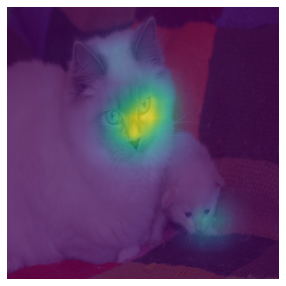

In [25]:
dls.train.decode((x_cat,))[0].squeeze().show()
plt.imshow(cam_cat_gradcam_original.squeeze(), alpha=0.7)

### Cat_GradCAM_Randombox

In [26]:
gradcam_randombox = GradCAM(model=lrnr2_r.model.to('cpu'), target_layers=lrnr2_r.model[0][-1])

In [27]:
cam_cat_gradcam_randombox = gradcam_randombox(input_tensor=x_cat_r,targets=None)

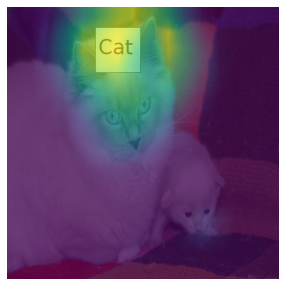

In [28]:
dls.train.decode((x_cat_r,))[0].squeeze().show()
plt.imshow(cam_cat_gradcam_randombox.squeeze(), alpha=0.7)

## Dog_GradCAM

### Dog_GradCAM_Original

In [29]:
cam_dog_gradcam_original = gradcam_original(input_tensor=x_dog,targets=None)

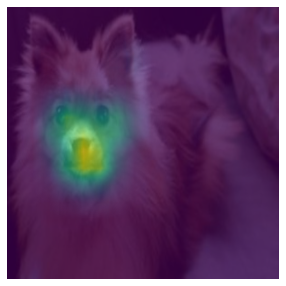

In [30]:
dls.train.decode((x_dog,))[0].squeeze().show()
plt.imshow(cam_dog_gradcam_original.squeeze(), alpha=0.7)

### Dog_GradCAM_Randombox

In [31]:
cam_dog_gradcam_randombox = gradcam_randombox(input_tensor=x_dog_r,targets=None)

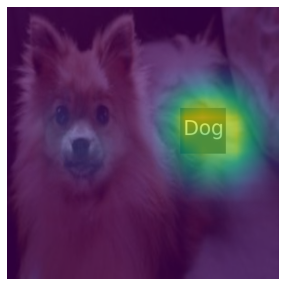

In [32]:
dls.train.decode((x_dog_r,))[0].squeeze().show()
plt.imshow(cam_dog_gradcam_randombox.squeeze(), alpha=0.7)

# HiResCAM

## Cat_HiResCAM

### Cat_HiResCAM_Original

In [33]:
hirescam_original = HiResCAM(model=lrnr2.model.to('cpu'), target_layers=lrnr2.model[0][-1])

In [34]:
cam_cat_hirescam_original = hirescam_original(input_tensor=x_cat,targets=None)

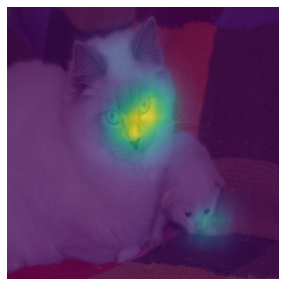

In [35]:
dls.train.decode((x_cat,))[0].squeeze().show()
plt.imshow(cam_cat_hirescam_original.squeeze(), alpha=0.7)

### Cat_HiResCAM_Randombox

In [36]:
hirescam_randombox = HiResCAM(model=lrnr2_r.model.to('cpu'), target_layers=lrnr2_r.model[0][-1])

In [37]:
cam_cat_hirescam_randombox = hirescam_randombox(input_tensor=x_cat_r,targets=None)

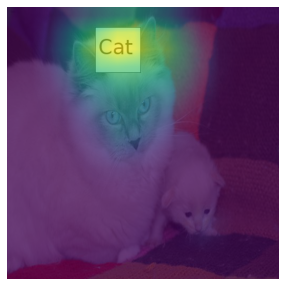

In [38]:
dls.train.decode((x_cat_r,))[0].squeeze().show()
plt.imshow(cam_cat_hirescam_randombox.squeeze(), alpha=0.7)

## Dog_HiResCAM

### Dog_HiResCAM_Original

In [39]:
cam_dog_hirescam_original = hirescam_original(input_tensor=x_dog,targets=None)

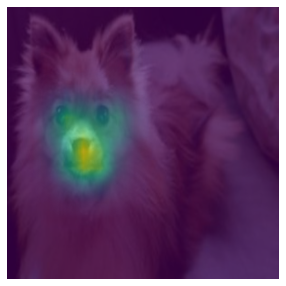

In [40]:
dls.train.decode((x_dog,))[0].squeeze().show()
plt.imshow(cam_dog_hirescam_original.squeeze(), alpha=0.7)

### Dog_HiResCAM_Random

In [41]:
cam_dog_hirescam_randombox = hirescam_randombox(input_tensor=x_dog_r,targets=None)

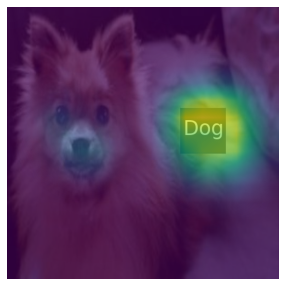

In [42]:
dls.train.decode((x_dog_r,))[0].squeeze().show()
plt.imshow(cam_dog_hirescam_randombox.squeeze(), alpha=0.7)

# ScoreCAM

## Cat_ScoreCAM

### Cat_ScoreCAM_Original

In [43]:
scorecam_original = ScoreCAM(model=lrnr2.model.to('cpu'), target_layers=lrnr2.model[0][-1])

In [44]:
cam_cat_scorecam_original = scorecam_original(input_tensor=x_cat,targets=None)

100%|██████████| 32/32 [00:25<00:00,  1.26it/s]


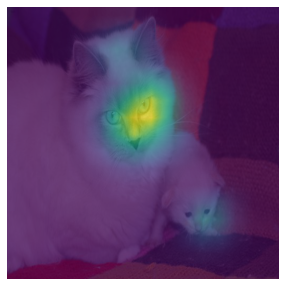

In [45]:
dls.train.decode((x_cat,))[0].squeeze().show()
plt.imshow(cam_cat_scorecam_original.squeeze(), alpha=0.7)

### Cat_ScoreCAM_Randombox

In [46]:
scorecam_randombox = ScoreCAM(model=lrnr2_r.model.to('cpu'), target_layers=lrnr2_r.model[0][-1])

In [47]:
cam_cat_scorecam_randombox = scorecam_randombox(input_tensor=x_cat_r,targets=None)

100%|██████████| 32/32 [00:25<00:00,  1.26it/s]


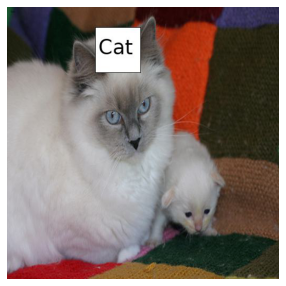

In [48]:
dls.train.decode((x_cat_r,))[0].squeeze().show()
plt.imshow(cam_cat_scorecam_randombox.squeeze(), alpha=0.7)

## Dog_ScoreCAM

### Dog_ScoreCAM_Original

In [52]:
cam_dog_scorecam_original = scorecam_original(input_tensor=x_dog,targets=None)

100%|██████████| 32/32 [00:24<00:00,  1.30it/s]


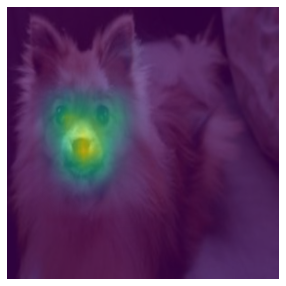

In [53]:
dls.train.decode((x_dog,))[0].squeeze().show()
plt.imshow(cam_dog_scorecam_original.squeeze(), alpha=0.7)

### Dog_ScoreCAM_Randombox

In [54]:
cam_dog_scorecam_randombox = scorecam_randombox(input_tensor=x_dog_r,targets=None)

100%|██████████| 32/32 [00:24<00:00,  1.29it/s]


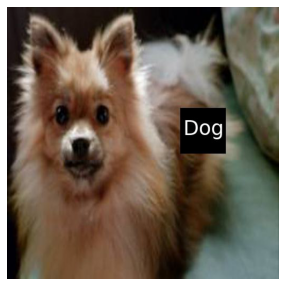

In [55]:
dls.train.decode((x_dog_r,))[0].squeeze().show()
plt.imshow(cam_dog_scorecam_randombox.squeeze(), alpha=0.7)

# GradCAMPlusPlus

## Cat_GradCAMPlusPlus

### Cat_GradCAMPlusPlus_Original

In [56]:
gradcamplusplus_original = GradCAMPlusPlus(model=lrnr2.model.to('cpu'), target_layers=lrnr2.model[0][-1])

In [57]:
cam_cat_gradcamplusplus_original = gradcamplusplus_original(input_tensor=x_cat,targets=None)

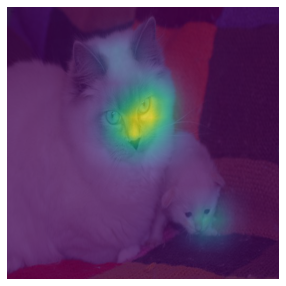

In [58]:
dls.train.decode((x_cat,))[0].squeeze().show()
plt.imshow(cam_cat_gradcamplusplus_original.squeeze(), alpha=0.7)

### Cat_GradCAMPlusPlus_Randombox

In [59]:
gradcamplusplus_randombox = GradCAMPlusPlus(model=lrnr2_r.model.to('cpu'), target_layers=lrnr2_r.model[0][-1])

In [60]:
cam_cat_gradcamplusplus_randombox = gradcamplusplus_randombox(input_tensor=x_cat_r,targets=None)

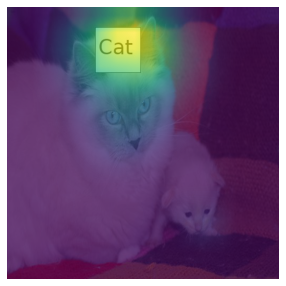

In [61]:
dls.train.decode((x_cat_r,))[0].squeeze().show()
plt.imshow(cam_cat_gradcamplusplus_randombox.squeeze(), alpha=0.7)

## Dog_GradCAMPlusPlus

### Dog_GradCAMPlusPlus_Original

In [62]:
cam_dog_gradcamplusplus_original = gradcamplusplus_original(input_tensor=x_dog,targets=None)

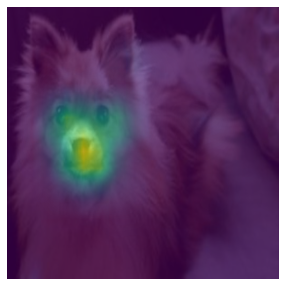

In [63]:
dls.train.decode((x_dog,))[0].squeeze().show()
plt.imshow(cam_dog_gradcamplusplus_original.squeeze(), alpha=0.7)

### Dog_GradCAMPlusPlus_Randombox

In [64]:
cam_dog_gradcamplusplus_randombox = gradcamplusplus_randombox(input_tensor=x_dog_r,targets=None)

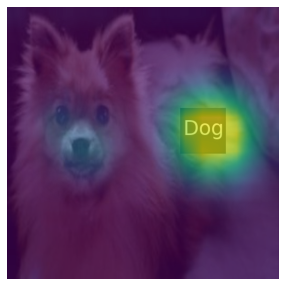

In [65]:
dls.train.decode((x_dog_r,))[0].squeeze().show()
plt.imshow(cam_dog_gradcamplusplus_randombox.squeeze(), alpha=0.7)

# AblationCAM

## Cat_AblationCAM

### Cat_AblationCAM_Original

In [66]:
ablationcam_original = AblationCAM(model=lrnr2.model.to('cpu'), target_layers=lrnr2.model[0][-1])

In [67]:
cam_cat_ablationcam_original = ablationcam_original(input_tensor=x_cat,targets=None)

100%|██████████| 16/16 [00:27<00:00,  1.72s/it]


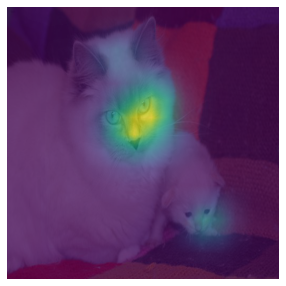

In [68]:
dls.train.decode((x_cat,))[0].squeeze().show()
plt.imshow(cam_cat_ablationcam_original.squeeze(), alpha=0.7)

### Cat_AblationCAM_Randombox

In [69]:
ablationcam_randombox = AblationCAM(model=lrnr2_r.model.to('cpu'), target_layers=lrnr2_r.model[0][-1])

In [70]:
cam_cat_ablationcam_randombox = ablationcam_randombox(input_tensor=x_cat_r,targets=None)

100%|██████████| 16/16 [00:25<00:00,  1.60s/it]


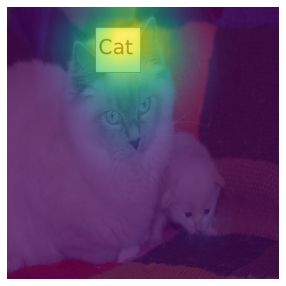

In [71]:
dls.train.decode((x_cat_r,))[0].squeeze().show()
plt.imshow(cam_cat_ablationcam_randombox.squeeze(), alpha=0.7)

## Dog_AblationCAM

### Dog_AblationCAM_Original

In [72]:
cam_dog_ablationcam_original = ablationcam_original(input_tensor=x_dog,targets=None)

100%|██████████| 16/16 [00:25<00:00,  1.58s/it]


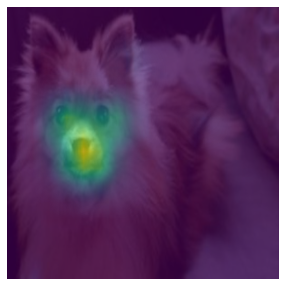

In [73]:
dls.train.decode((x_dog,))[0].squeeze().show()
plt.imshow(cam_dog_ablationcam_original.squeeze(), alpha=0.7)

### Dog_AblationCAM_Randombox

In [74]:
cam_dog_ablationcam_randombox = ablationcam_randombox(input_tensor=x_dog_r,targets=None)

100%|██████████| 16/16 [00:25<00:00,  1.59s/it]


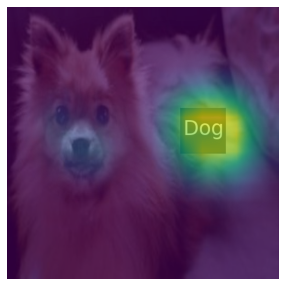

In [75]:
dls.train.decode((x_dog_r,))[0].squeeze().show()
plt.imshow(cam_dog_ablationcam_randombox.squeeze(), alpha=0.7)

# XGradCAM

## Cat_XGradCAM

### Cat_XGradCAM_Original

In [76]:
xgradcam_original = XGradCAM(model=lrnr2.model.to('cpu'), target_layers=lrnr2.model[0][-1])

In [77]:
cam_cat_xgradcam_original = xgradcam_original(input_tensor=x_cat,targets=None)

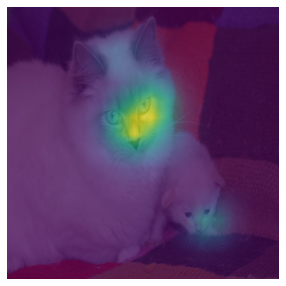

In [78]:
dls.train.decode((x_cat,))[0].squeeze().show()
plt.imshow(cam_cat_xgradcam_original.squeeze(), alpha=0.7)

### Cat_XGradCAM_Randombox

In [79]:
xgradcam_randombox = XGradCAM(model=lrnr2_r.model.to('cpu'), target_layers=lrnr2_r.model[0][-1])

In [80]:
cam_cat_xgradcam_randombox = xgradcam_randombox(input_tensor=x_cat_r,targets=None)

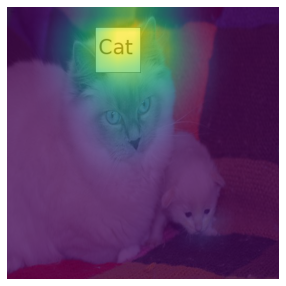

In [81]:
dls.train.decode((x_cat_r,))[0].squeeze().show()
plt.imshow(cam_cat_xgradcam_randombox.squeeze(), alpha=0.7)

## Dog_XGradCAM

### Dog_XGradCAM_Original

In [82]:
cam_dog_xgradcam_original = xgradcam_original(input_tensor=x_dog,targets=None)

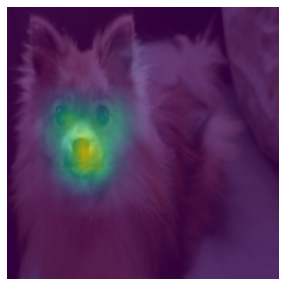

In [83]:
dls.train.decode((x_dog,))[0].squeeze().show()
plt.imshow(cam_dog_xgradcam_original.squeeze(), alpha=0.7)

### Dog_XGradCAM_Randombox

In [84]:
cam_dog_xgradcam_randombox = xgradcam_randombox(input_tensor=x_dog_r,targets=None)

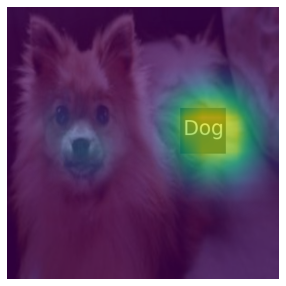

In [85]:
dls.train.decode((x_dog_r,))[0].squeeze().show()
plt.imshow(cam_dog_xgradcam_randombox.squeeze(), alpha=0.7)

# EigenCAM

## Cat_EigenCAM

### Cat_EigenCAM_Original

In [86]:
eigencam_original = EigenCAM(model=lrnr2.model.to('cpu'), target_layers=lrnr2.model[0][-1])

In [87]:
cam_cat_eigencam_original = eigencam_original(input_tensor=x_cat,targets=None)

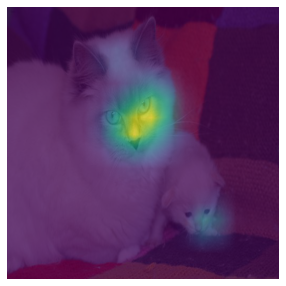

In [88]:
dls.train.decode((x_cat,))[0].squeeze().show()
plt.imshow(cam_cat_eigencam_original.squeeze(), alpha=0.7)

### Cat_EigenCAM_Randombox

In [89]:
eigencam_randombox = EigenCAM(model=lrnr2_r.model.to('cpu'), target_layers=lrnr2_r.model[0][-1])

In [90]:
cam_cat_eigencam_randombox = eigencam_randombox(input_tensor=x_cat_r,targets=None)

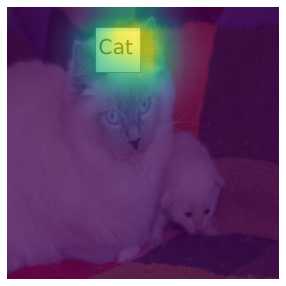

In [91]:
dls.train.decode((x_cat_r,))[0].squeeze().show()
plt.imshow(cam_cat_eigencam_randombox.squeeze(), alpha=0.7)

## Dog_EigenCAM

### Dog_EigenCAM_Original

In [92]:
cam_dog_eigencam_original = eigencam_original(input_tensor=x_dog,targets=None)

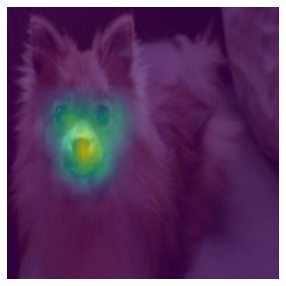

In [93]:
dls.train.decode((x_dog,))[0].squeeze().show()
plt.imshow(cam_dog_eigencam_original.squeeze(), alpha=0.7)

### Dog_EigenCAM_Randombox

In [94]:
cam_dog_eigencam_randombox = eigencam_randombox(input_tensor=x_dog_r,targets=None)

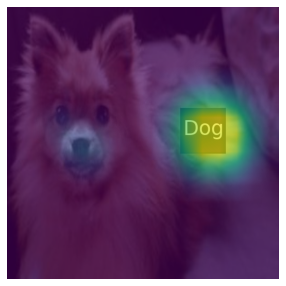

In [95]:
dls.train.decode((x_dog_r,))[0].squeeze().show()
plt.imshow(cam_dog_eigencam_randombox.squeeze(), alpha=0.7)

# FullGrad

## Cat_FullGrad

### Cat_FullGrad_Original

In [96]:
fullgrad_original = FullGrad(model=lrnr2.model.to('cpu'), target_layers=lrnr2.model[0][-1])

In [97]:
cam_cat_fullgrad_original = fullgrad_original(input_tensor=x_cat,targets=None)

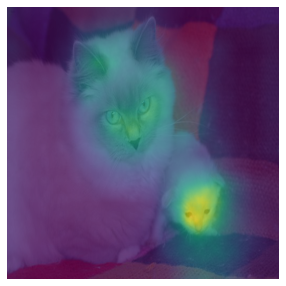

In [98]:
dls.train.decode((x_cat,))[0].squeeze().show()
plt.imshow(cam_cat_fullgrad_original.squeeze(), alpha=0.7)

### Cat_FullGrad_Randombox

In [99]:
fullgrad_randombox = FullGrad(model=lrnr2_r.model.to('cpu'), target_layers=lrnr2_r.model[0][-1])

In [100]:
cam_cat_fullgrad_randombox = fullgrad_randombox(input_tensor=x_cat_r,targets=None)

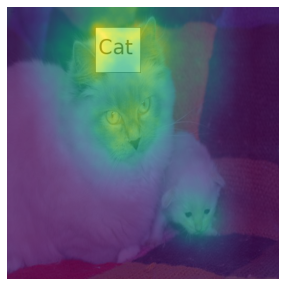

In [101]:
dls.train.decode((x_cat_r,))[0].squeeze().show()
plt.imshow(cam_cat_fullgrad_randombox.squeeze(), alpha=0.7)

## Dog_FullGrad

### Dog_FullGrad_Original

In [102]:
cam_dog_fullgrad_original = fullgrad_original(input_tensor=x_dog,targets=None)

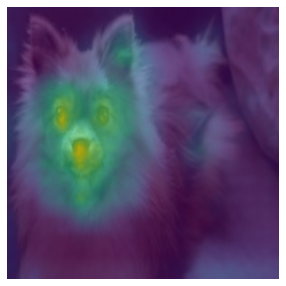

In [103]:
dls.train.decode((x_dog,))[0].squeeze().show()
plt.imshow(cam_dog_fullgrad_original.squeeze(), alpha=0.7)

### Dog_FullGrad_Randombox

In [104]:
cam_dog_fullgrad_randombox = fullgrad_randombox(input_tensor=x_dog_r,targets=None)

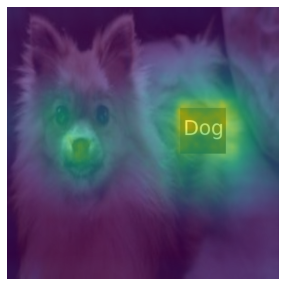

In [105]:
dls.train.decode((x_dog_r,))[0].squeeze().show()
plt.imshow(cam_dog_fullgrad_randombox.squeeze(), alpha=0.7)

# EigenGradCAM

## Cat_EigenGradCAM

### Cat_EigenGradCAM_Original

In [106]:
eigengradcam_original = EigenGradCAM(model=lrnr2.model.to('cpu'), target_layers=lrnr2.model[0][-1])

In [107]:
cam_cat_eigengradcam_original = eigengradcam_original(input_tensor=x_cat,targets=None)

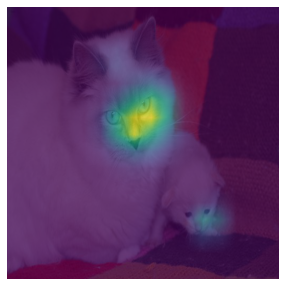

In [108]:
dls.train.decode((x_cat,))[0].squeeze().show()
plt.imshow(cam_cat_eigengradcam_original.squeeze(), alpha=0.7)

### Cat_EigenGradCAM_Randombox

In [109]:
eigengradcam_randombox = EigenGradCAM(model=lrnr2_r.model.to('cpu'), target_layers=lrnr2_r.model[0][-1])

In [110]:
cam_cat_eigengradcam_randombox = eigengradcam_randombox(input_tensor=x_cat_r,targets=None)

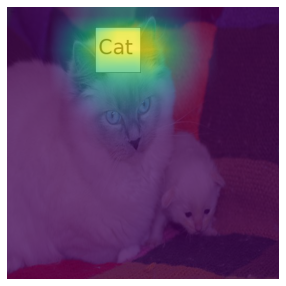

In [111]:
dls.train.decode((x_cat_r,))[0].squeeze().show()
plt.imshow(cam_cat_eigengradcam_randombox.squeeze(), alpha=0.7)

## Dog_EigenGradCAM

### Dog_EigenGradCAM_Original

In [112]:
cam_dog_eigengradcam_original = eigengradcam_original(input_tensor=x_dog,targets=None)

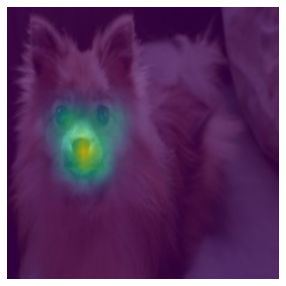

In [113]:
dls.train.decode((x_dog,))[0].squeeze().show()
plt.imshow(cam_dog_eigengradcam_original.squeeze(), alpha=0.7)

### Dog_EigenGradCAM_Randombox

In [114]:
cam_dog_eigengradcam_randombox = eigengradcam_randombox(input_tensor=x_dog_r,targets=None)

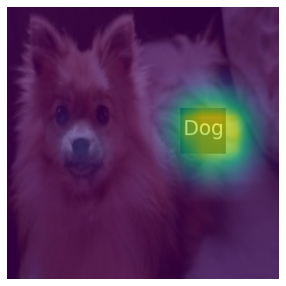

In [115]:
dls.train.decode((x_dog_r,))[0].squeeze().show()
plt.imshow(cam_dog_eigengradcam_randombox.squeeze(), alpha=0.7)

# LayerCAM

## Cat_LayerCAM

### Cat_LayerCAM_Original

In [116]:
layercam_original = LayerCAM(model=lrnr2.model.to('cpu'), target_layers=lrnr2.model[0][-1])

In [117]:
cam_cat_layercam_original = layercam_original(input_tensor=x_cat,targets=None)

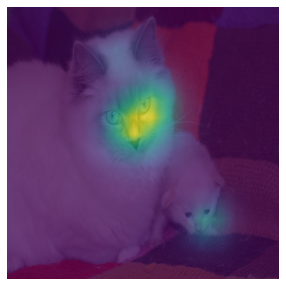

In [118]:
dls.train.decode((x_cat,))[0].squeeze().show()
plt.imshow(cam_cat_layercam_original.squeeze(), alpha=0.7)

### Cat_LayerCAM_Randombox

In [119]:
layercam_randombox = LayerCAM(model=lrnr2_r.model.to('cpu'), target_layers=lrnr2_r.model[0][-1])

In [120]:
cam_cat_layercam_randombox = layercam_randombox(input_tensor=x_cat_r,targets=None)

In [ ]:
dls.train.decode((x_cat_r,))[0].squeeze().show()
plt.imshow(cam_cat_layercam_randombox.squeeze(), alpha=0.7)

## Dog_LayerCAM

## Dog_LayerCAM_Original

In [122]:
cam_dog_layercam_original = layercam_original(input_tensor=x_dog,targets=None)

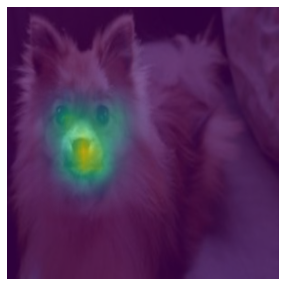

In [123]:
dls.train.decode((x_dog,))[0].squeeze().show()
plt.imshow(cam_dog_layercam_original.squeeze(), alpha=0.7)

## Dog_LayerCAM_Randombox

In [124]:
cam_dog_layercam_randombox = layercam_randombox(input_tensor=x_dog_r,targets=None)

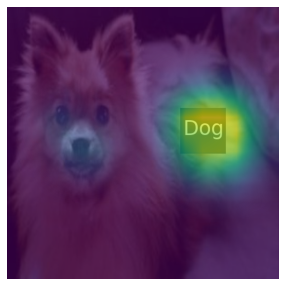

In [125]:
dls.train.decode((x_dog_r,))[0].squeeze().show()
plt.imshow(cam_dog_layercam_randombox.squeeze(), alpha=0.7)

# Figure

## Figure_Original

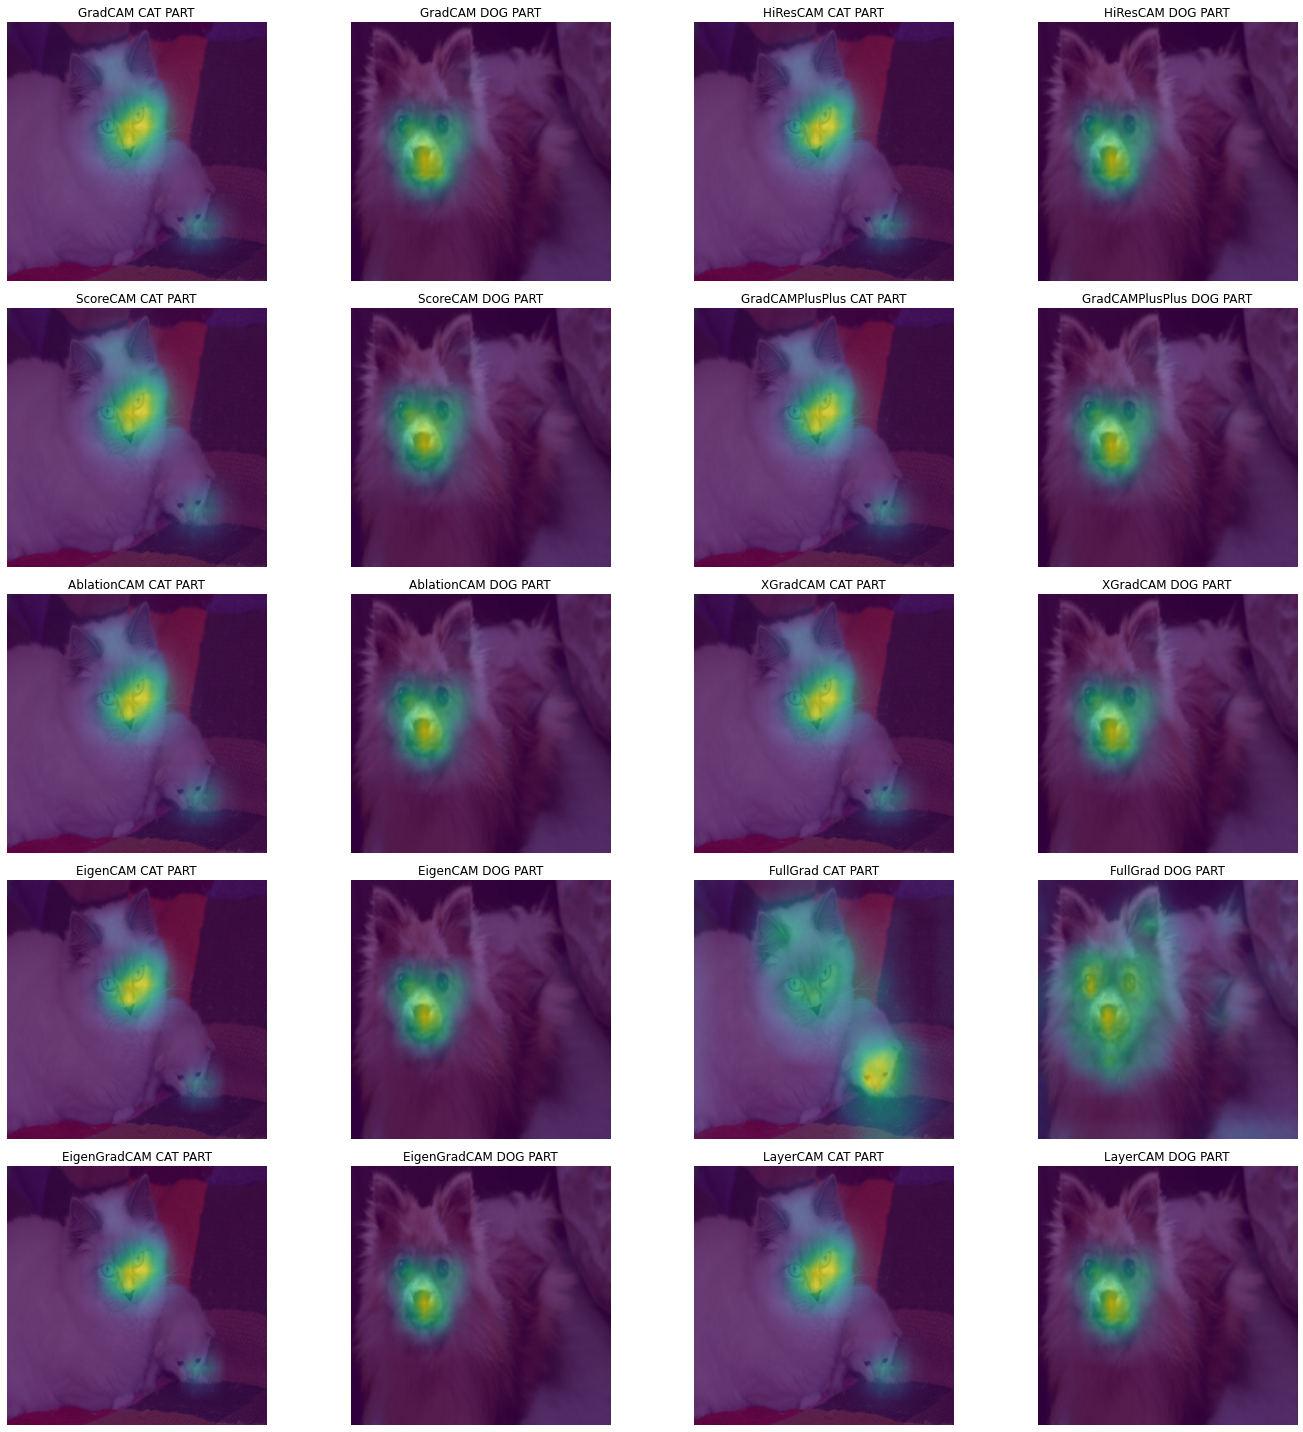

In [126]:
fig, ((ax1,ax2,ax3,ax4),
      (ax5,ax6,ax7,ax8),
      (ax9,ax10,ax11,ax12),
      (ax13,ax14,ax15,ax16),
     (ax17,ax18,ax19,ax20)) = plt.subplots(5,4) 
plt.title('Original')
#
dls.train.decode((x_cat,))[0].squeeze().show(ax=ax1)
ax1.imshow(cam_cat_gradcam_original.squeeze(), alpha=0.7)
ax1.set_title("GradCAM CAT PART")
#
dls.train.decode((x_dog,))[0].squeeze().show(ax=ax2)
ax2.imshow(cam_dog_gradcam_original.squeeze(), alpha=0.7)
ax2.set_title("GradCAM DOG PART")
#
dls.train.decode((x_cat,))[0].squeeze().show(ax=ax3)
ax3.imshow(cam_cat_hirescam_original.squeeze(), alpha=0.7)
ax3.set_title("HiResCAM CAT PART")
#
dls.train.decode((x_dog,))[0].squeeze().show(ax=ax4)
ax4.imshow(cam_dog_hirescam_original.squeeze(), alpha=0.7)
ax4.set_title("HiResCAM DOG PART")
#
dls.train.decode((x_cat,))[0].squeeze().show(ax=ax5)
ax5.imshow(cam_cat_scorecam_original.squeeze(), alpha=0.7)
ax5.set_title("ScoreCAM CAT PART")
#
dls.train.decode((x_dog,))[0].squeeze().show(ax=ax6)
ax6.imshow(cam_dog_scorecam_original.squeeze(), alpha=0.7)
ax6.set_title("ScoreCAM DOG PART")
#
dls.train.decode((x_cat,))[0].squeeze().show(ax=ax7)
ax7.imshow(cam_cat_gradcamplusplus_original.squeeze(), alpha=0.7)
ax7.set_title("GradCAMPlusPlus CAT PART")
#
dls.train.decode((x_dog,))[0].squeeze().show(ax=ax8)
ax8.imshow(cam_dog_gradcamplusplus_original.squeeze(), alpha=0.7)
ax8.set_title("GradCAMPlusPlus DOG PART")
#
dls.train.decode((x_cat,))[0].squeeze().show(ax=ax9)
ax9.imshow(cam_cat_ablationcam_original.squeeze(), alpha=0.7)
ax9.set_title("AblationCAM CAT PART")
#
dls.train.decode((x_dog,))[0].squeeze().show(ax=ax10)
ax10.imshow(cam_dog_ablationcam_original.squeeze(), alpha=0.7)
ax10.set_title("AblationCAM DOG PART")
#
dls.train.decode((x_cat,))[0].squeeze().show(ax=ax11)
ax11.imshow(cam_cat_xgradcam_original.squeeze(), alpha=0.7)
ax11.set_title("XGradCAM CAT PART")
#
dls.train.decode((x_dog,))[0].squeeze().show(ax=ax12)
ax12.imshow(cam_dog_xgradcam_original.squeeze(), alpha=0.7)
ax12.set_title("XGradCAM DOG PART")
#
dls.train.decode((x_cat,))[0].squeeze().show(ax=ax13)
ax13.imshow(cam_cat_eigencam_original.squeeze(), alpha=0.7)
ax13.set_title("EigenCAM CAT PART")
#
dls.train.decode((x_dog,))[0].squeeze().show(ax=ax14)
ax14.imshow(cam_dog_eigencam_original.squeeze(), alpha=0.7)
ax14.set_title("EigenCAM DOG PART")
#
dls.train.decode((x_cat,))[0].squeeze().show(ax=ax15)
ax15.imshow(cam_cat_fullgrad_original.squeeze(), alpha=0.7)
ax15.set_title("FullGrad CAT PART")
#
dls.train.decode((x_dog,))[0].squeeze().show(ax=ax16)
ax16.imshow(cam_dog_fullgrad_original.squeeze(), alpha=0.7)
ax16.set_title("FullGrad DOG PART")
#
dls.train.decode((x_cat,))[0].squeeze().show(ax=ax17)
ax17.imshow(cam_cat_eigengradcam_original.squeeze(), alpha=0.7)
ax17.set_title("EigenGradCAM CAT PART")
#
dls.train.decode((x_dog,))[0].squeeze().show(ax=ax18)
ax18.imshow(cam_dog_eigengradcam_original.squeeze(), alpha=0.7)
ax18.set_title("EigenGradCAM DOG PART")
#
dls.train.decode((x_cat,))[0].squeeze().show(ax=ax19)
ax19.imshow(cam_cat_layercam_original.squeeze(), alpha=0.7)
ax19.set_title("LayerCAM CAT PART")
#
dls.train.decode((x_dog,))[0].squeeze().show(ax=ax20)
ax20.imshow(cam_dog_layercam_original.squeeze(), alpha=0.7)
ax20.set_title("LayerCAM DOG PART")
#
fig.set_figwidth(20)            
fig.set_figheight(20)
fig.tight_layout()

## Figure_Randombox

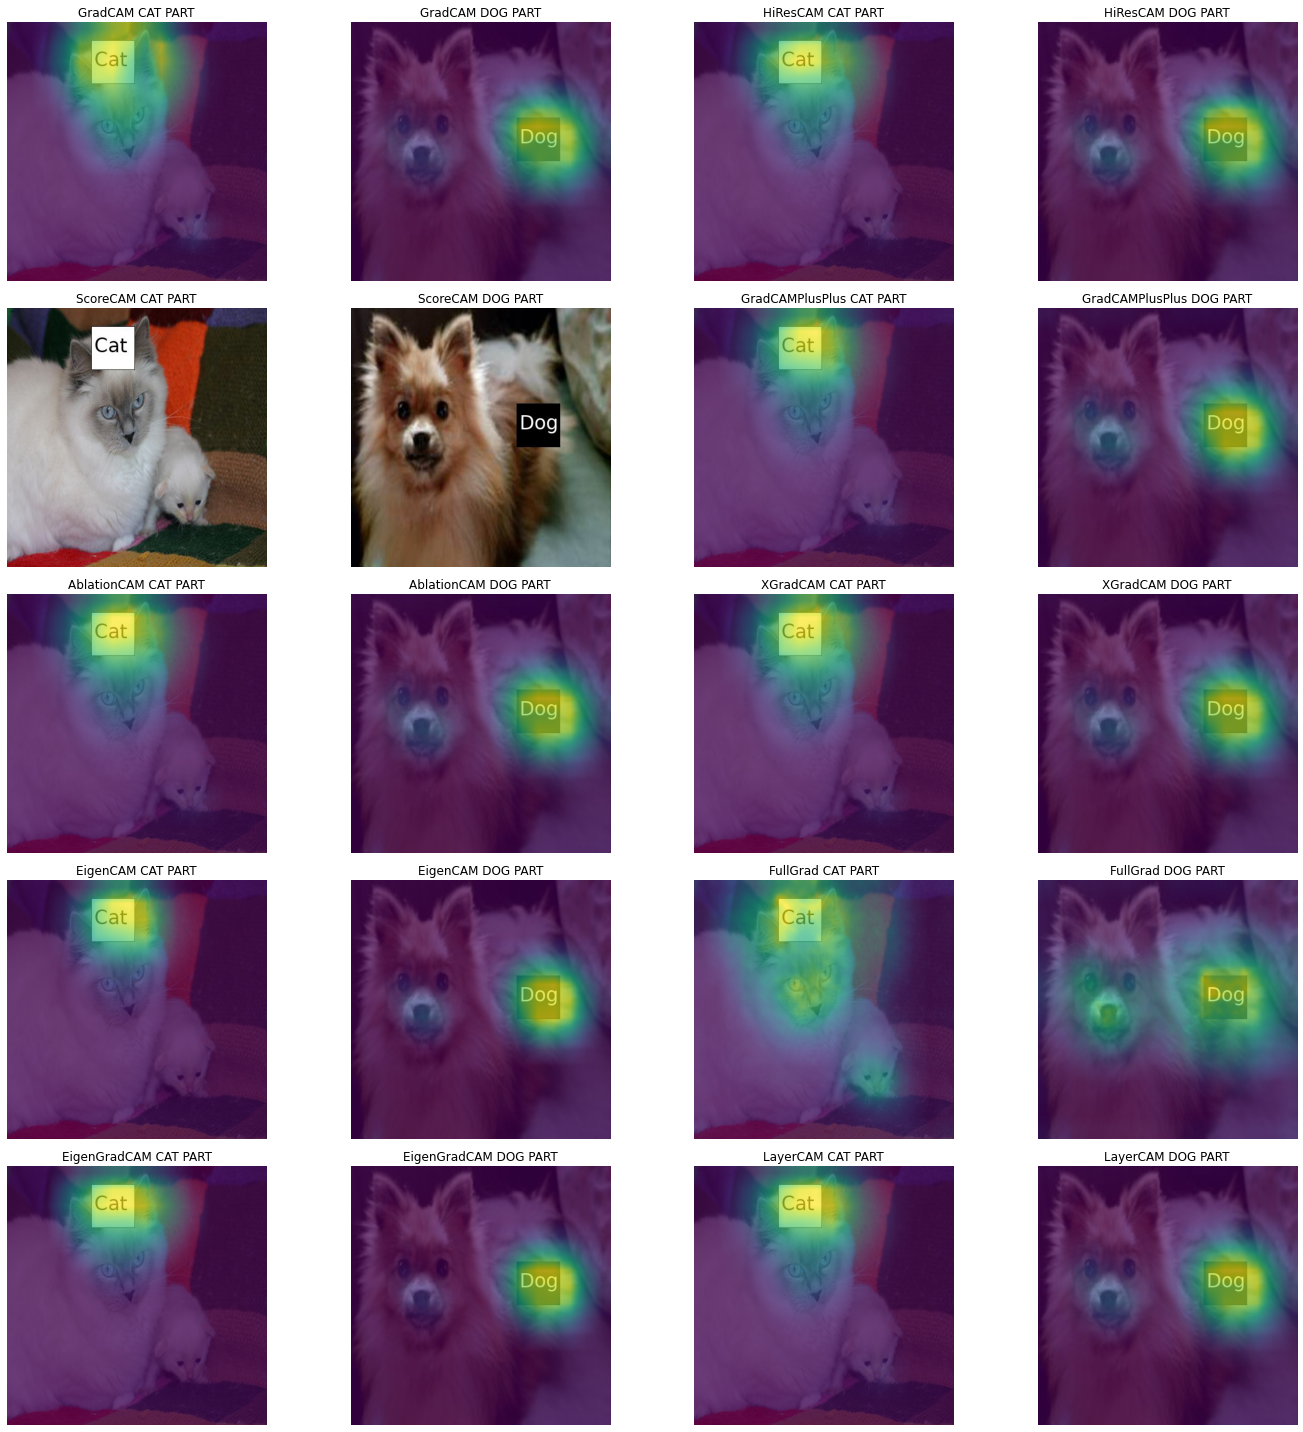

In [128]:
fig, ((ax1,ax2,ax3,ax4),
      (ax5,ax6,ax7,ax8),
      (ax9,ax10,ax11,ax12),
      (ax13,ax14,ax15,ax16),
     (ax17,ax18,ax19,ax20)) = plt.subplots(5,4) 
plt.title('Randombox')
#
dls.train.decode((x_cat_r,))[0].squeeze().show(ax=ax1)
ax1.imshow(cam_cat_gradcam_randombox.squeeze(), alpha=0.7)
ax1.set_title("GradCAM CAT PART")
#
dls.train.decode((x_dog_r,))[0].squeeze().show(ax=ax2)
ax2.imshow(cam_dog_gradcam_randombox.squeeze(), alpha=0.7)
ax2.set_title("GradCAM DOG PART")
#
dls.train.decode((x_cat_r,))[0].squeeze().show(ax=ax3)
ax3.imshow(cam_cat_hirescam_randombox.squeeze(), alpha=0.7)
ax3.set_title("HiResCAM CAT PART")
#
dls.train.decode((x_dog_r,))[0].squeeze().show(ax=ax4)
ax4.imshow(cam_dog_hirescam_randombox.squeeze(), alpha=0.7)
ax4.set_title("HiResCAM DOG PART")
#
dls.train.decode((x_cat_r,))[0].squeeze().show(ax=ax5)
ax5.imshow(cam_cat_scorecam_randombox.squeeze(), alpha=0.7)
ax5.set_title("ScoreCAM CAT PART")
#
dls.train.decode((x_dog_r,))[0].squeeze().show(ax=ax6)
ax6.imshow(cam_dog_scorecam_randombox.squeeze(), alpha=0.7)
ax6.set_title("ScoreCAM DOG PART")
#
dls.train.decode((x_cat_r,))[0].squeeze().show(ax=ax7)
ax7.imshow(cam_cat_gradcamplusplus_randombox.squeeze(), alpha=0.7)
ax7.set_title("GradCAMPlusPlus CAT PART")
#
dls.train.decode((x_dog_r,))[0].squeeze().show(ax=ax8)
ax8.imshow(cam_dog_gradcamplusplus_randombox.squeeze(), alpha=0.7)
ax8.set_title("GradCAMPlusPlus DOG PART")
#
dls.train.decode((x_cat_r,))[0].squeeze().show(ax=ax9)
ax9.imshow(cam_cat_ablationcam_randombox.squeeze(), alpha=0.7)
ax9.set_title("AblationCAM CAT PART")
#
dls.train.decode((x_dog_r,))[0].squeeze().show(ax=ax10)
ax10.imshow(cam_dog_ablationcam_randombox.squeeze(), alpha=0.7)
ax10.set_title("AblationCAM DOG PART")
#
dls.train.decode((x_cat_r,))[0].squeeze().show(ax=ax11)
ax11.imshow(cam_cat_xgradcam_randombox.squeeze(), alpha=0.7)
ax11.set_title("XGradCAM CAT PART")
#
dls.train.decode((x_dog_r,))[0].squeeze().show(ax=ax12)
ax12.imshow(cam_dog_xgradcam_randombox.squeeze(), alpha=0.7)
ax12.set_title("XGradCAM DOG PART")
#
dls.train.decode((x_cat_r,))[0].squeeze().show(ax=ax13)
ax13.imshow(cam_cat_eigencam_randombox.squeeze(), alpha=0.7)
ax13.set_title("EigenCAM CAT PART")
#
dls.train.decode((x_dog_r,))[0].squeeze().show(ax=ax14)
ax14.imshow(cam_dog_eigencam_randombox.squeeze(), alpha=0.7)
ax14.set_title("EigenCAM DOG PART")
#
dls.train.decode((x_cat_r,))[0].squeeze().show(ax=ax15)
ax15.imshow(cam_cat_fullgrad_randombox.squeeze(), alpha=0.7)
ax15.set_title("FullGrad CAT PART")
#
dls.train.decode((x_dog_r,))[0].squeeze().show(ax=ax16)
ax16.imshow(cam_dog_fullgrad_randombox.squeeze(), alpha=0.7)
ax16.set_title("FullGrad DOG PART")
#
dls.train.decode((x_cat_r,))[0].squeeze().show(ax=ax17)
ax17.imshow(cam_cat_eigengradcam_randombox.squeeze(), alpha=0.7)
ax17.set_title("EigenGradCAM CAT PART")
#
dls.train.decode((x_dog_r,))[0].squeeze().show(ax=ax18)
ax18.imshow(cam_dog_eigengradcam_randombox.squeeze(), alpha=0.7)
ax18.set_title("EigenGradCAM DOG PART")
#
dls.train.decode((x_cat_r,))[0].squeeze().show(ax=ax19)
ax19.imshow(cam_cat_layercam_randombox.squeeze(), alpha=0.7)
ax19.set_title("LayerCAM CAT PART")
#
dls.train.decode((x_dog_r,))[0].squeeze().show(ax=ax20)
ax20.imshow(cam_dog_layercam_randombox.squeeze(), alpha=0.7)
ax20.set_title("LayerCAM DOG PART")
#
fig.set_figwidth(20)            
fig.set_figheight(20)
fig.tight_layout()